In [1]:

import os
import random
import skimage.data
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
print "dhd"

SyntaxError: Missing parentheses in call to 'print' (<ipython-input-2-2f92644bf030>, line 1)

In [3]:
def load_data(data_dir):
    
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]

    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) if f.endswith(".ppm")]

        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    return images, labels



ROOT_PATH = "/traffic"
train_data_dir = os.path.join(ROOT_PATH, "datasets/BelgiumTS/Training")
test_data_dir = os.path.join(ROOT_PATH, "datasets/BelgiumTS/Testing")

images, labels = load_data(train_data_dir)

In [4]:
print("Unique Labels: {0}\nTotal Images: {1}".format(len(set(labels)), len(images)))

Unique Labels: 62
Total Images: 4575


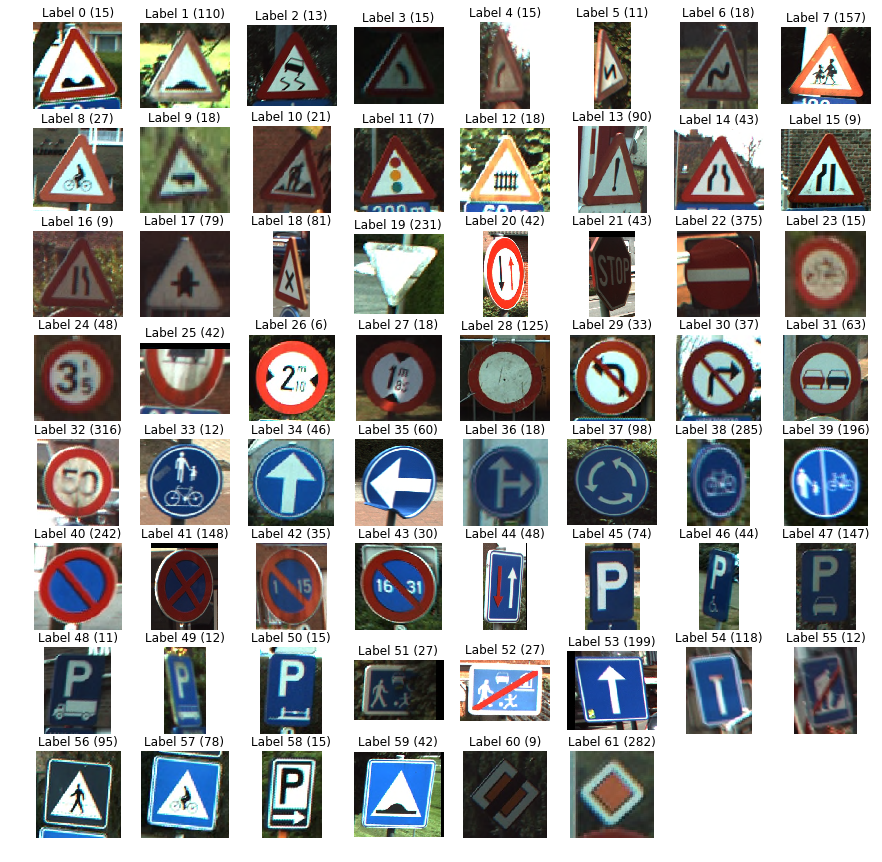

In [5]:
def display_images_and_labels(images, labels):
   
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)
    plt.show()

display_images_and_labels(images, labels)

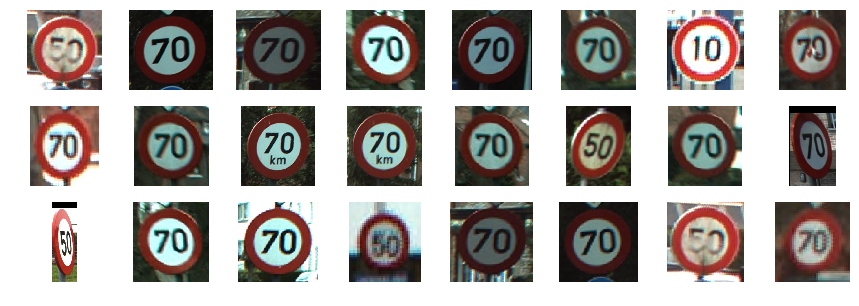

In [6]:

def display_label_images(images, label):
    """Display images of a specific label."""
    limit = 24  
    plt.figure(figsize=(15, 5))
    i = 1

    start = labels.index(label)
    end = start + labels.count(label)
    for image in images[start:end][:limit]:
        plt.subplot(3, 8, i)  
        plt.axis('off')
        i += 1
        plt.imshow(image)
    plt.show()

display_label_images(images, 30)


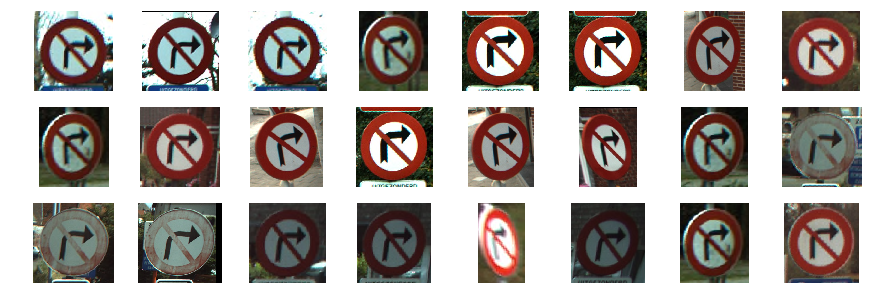

In [7]:
display_label_images(images, 30)


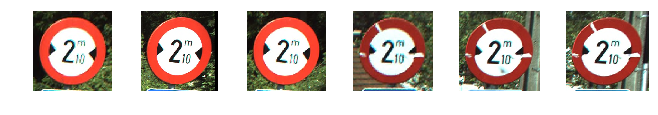

In [8]:
display_label_images(images, 26)

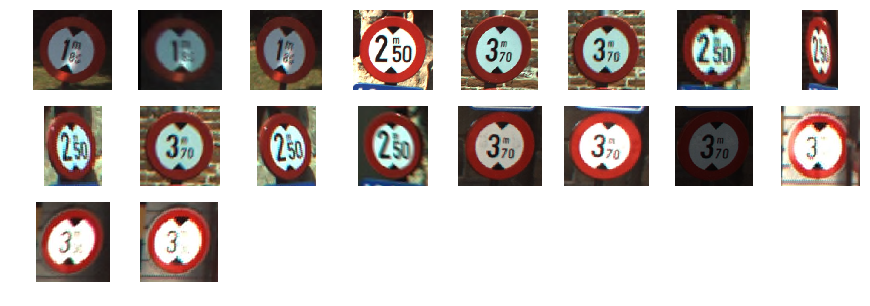

In [9]:
display_label_images(images, 27)

In [10]:

for image in images[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (144, 141, 3), min: 3, max: 255
shape: (183, 187, 3), min: 0, max: 255
shape: (244, 253, 3), min: 0, max: 255
shape: (99, 97, 3), min: 4, max: 247
shape: (145, 146, 3), min: 0, max: 255


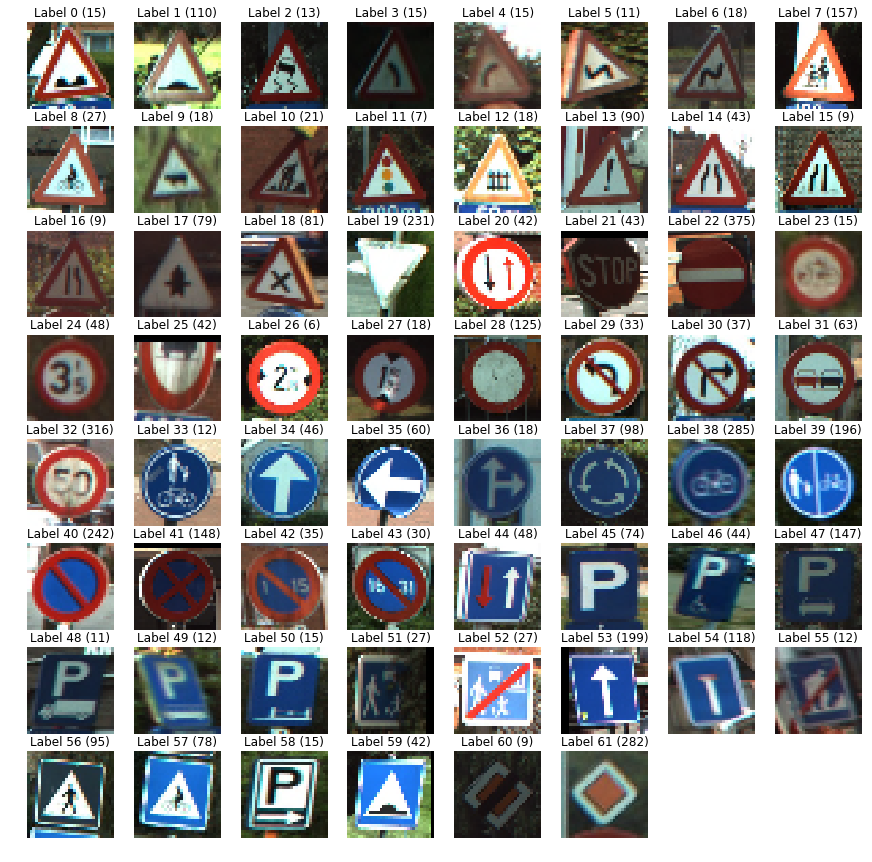

In [11]:
# Resize images
images32 = [skimage.transform.resize(image, (32, 32), mode='constant')
                for image in images]
display_images_and_labels(images32, labels)

In [12]:

%matplotlib inline

In [13]:
for image in images32[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (32, 32, 3), min: 0.06064644607842559, max: 0.9841758578431372
shape: (32, 32, 3), min: 0.03687097886029466, max: 1.0
shape: (32, 32, 3), min: 0.044450827205882476, max: 0.9980583639705883
shape: (32, 32, 3), min: 0.06574754901960768, max: 0.9211693857230396
shape: (32, 32, 3), min: 0.0508003982843127, max: 1.0


In [14]:
labels_a = np.array(labels)
images_a = np.array(images32)
print("labels: ", labels_a.shape, "\nimages: ", images_a.shape)

labels:  (4575,) 
images:  (4575, 32, 32, 3)


In [15]:
# Create graph
graph = tf.Graph()

# Create model in the graph.
with graph.as_default():
    # Placeholders 
    images_ph = tf.placeholder(tf.float32, [None, 32, 32, 3])
    labels_ph = tf.placeholder(tf.int32, [None])

    # Flatten input 
    images_flat = tf.contrib.layers.flatten(images_ph)

    # Fully connected layer. 
    logits = tf.contrib.layers.fully_connected(images_flat, 62, tf.nn.relu)

    # Convert logits to label indexes (int).
    # Shape [None], which is a 1D vector of length == batch_size.
    predicted_labels = tf.argmax(logits, 1)

    # Define the loss function. 
    # Cross-entropy 
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels_ph))

    # Create training op.
    train = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

    # initialization op to execute before training.
    init = tf.global_variables_initializer()

print("images_flat: ", images_flat)
print("logits: ", logits)
print("loss: ", loss)
print("predicted_labels: ", predicted_labels)

images_flat:  Tensor("Flatten/flatten/Reshape:0", shape=(?, 3072), dtype=float32)
logits:  Tensor("fully_connected/Relu:0", shape=(?, 62), dtype=float32)
loss:  Tensor("Mean:0", shape=(), dtype=float32)
predicted_labels:  Tensor("ArgMax:0", shape=(?,), dtype=int64)


In [16]:

session = tf.Session(graph=graph)

_ = session.run([init])

In [17]:
for i in range(201):
    _, loss_value = session.run([train, loss], 
                                feed_dict={images_ph: images_a, labels_ph: labels_a})
    if i % 10 == 0:
        print("Loss: ", loss_value)
        

Loss:  4.1777163
Loss:  3.016775
Loss:  2.5947776
Loss:  2.397815
Loss:  2.280246
Loss:  2.1992242
Loss:  2.1377547
Loss:  2.0887535
Loss:  2.047887
Loss:  2.0125656
Loss:  1.9819922
Loss:  1.955154
Loss:  1.9312886
Loss:  1.9099735
Loss:  1.8907954
Loss:  1.8734317
Loss:  1.8576449
Loss:  1.8432227
Loss:  1.8299806
Loss:  1.8177727
Loss:  1.8064733


In [18]:
# 10 random images
sample_indexes = random.sample(range(len(images32)), 10)
sample_images = [images32[i] for i in sample_indexes]
sample_labels = [labels[i] for i in sample_indexes]

# Run the "predicted_labels" op.
predicted = session.run([predicted_labels], 
                        feed_dict={images_ph: sample_images})[0]
print(sample_labels)
print(predicted)

[61, 38, 7, 57, 61, 19, 54, 30, 41, 40]
[19 38  7 57 37 19 38 32 41 40]


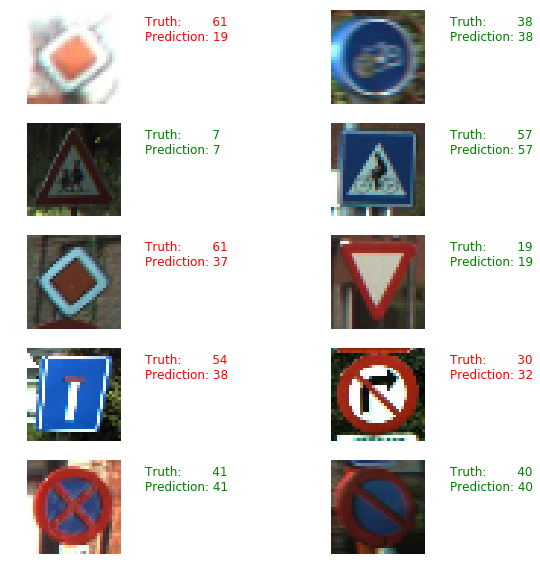

In [19]:
# Display the predictions and the ground truth visually.
fig = plt.figure(figsize=(10, 10))
for i in range(len(sample_images)):
    truth = sample_labels[i]
    prediction = predicted[i]
    plt.subplot(5, 2,1+i)
    plt.axis('off')
    color='green' if truth == prediction else 'red'
    plt.text(40, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
             fontsize=12, color=color)
    plt.imshow(sample_images[i])


In [20]:
# Load the test dataset.
test_images, test_labels = load_data(test_data_dir)

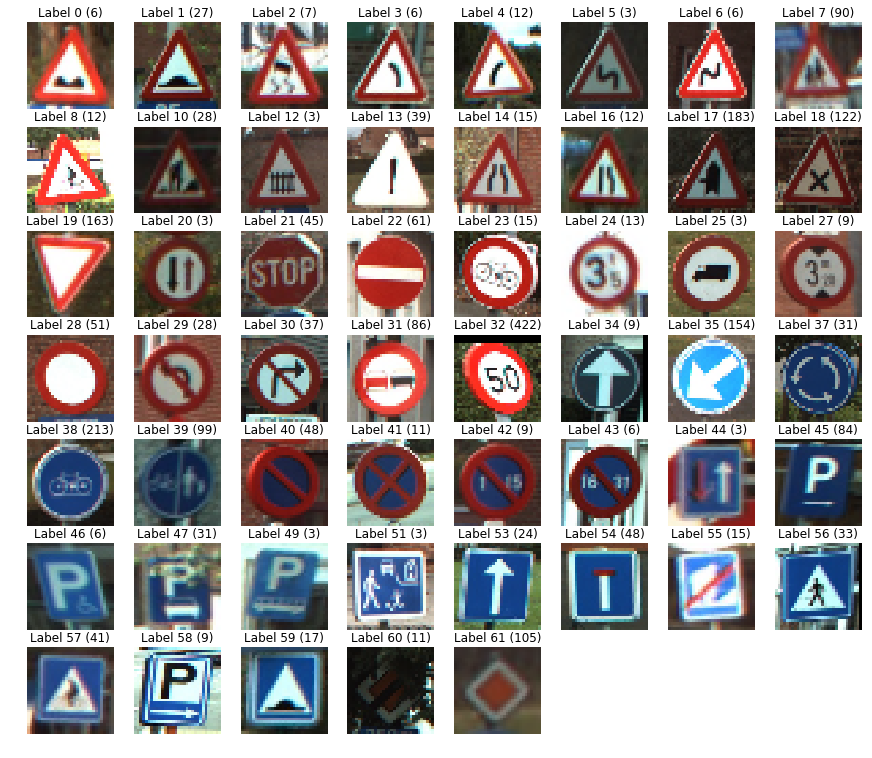

In [21]:
# Transform the images
test_images32 = [skimage.transform.resize(image, (32, 32), mode='constant')
                 for image in test_images]
display_images_and_labels(test_images32, test_labels)

In [22]:
# Run predictions against the full test set.
predicted = session.run([predicted_labels], 
                        feed_dict={images_ph: test_images32})[0]
# Calculate how many matches we got.
match_count = sum([int(y == y_) for y, y_ in zip(test_labels, predicted)])
accuracy = match_count / len(test_labels)
print("Accuracy: {:.3f}".format(accuracy))

Accuracy: 0.664
